In [1]:
import dataset_loader
import matplotlib.pyplot as plt
import midi
import numpy as np
import similarity

In [2]:
DATASET_ROOT="../../sabana/dataset/asap-dataset"

SLICE_DURATION = 5 # sec
EXPANSION_RATE = 1.5
FRAME_PER_SECOND = 20 # Hz
NUM_SAMPLES = 1
SETTLING_FRAME = 8
COMPENSATION_FRAME = 0

In [3]:
def plot_midi_matrix(matrix: np.ndarray, title: str, head: int = None, tail: int = None):
    plt.figure(figsize=(16, 3))
    plt.title(title)
    plt.imshow(matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    if head:
        plt.plot([head, head], [0, 128])
    if tail:
        plt.plot([tail, tail], [0, 128])
    plt.ylabel("MIDI Key")
    plt.xlabel("Frame")
    plt.show()
    plt.clf()
    return None

In [4]:
def process_midi_matrix(midi_matrix: np.ndarray, settling_frame):
    prev_pressed = [False] * midi.NUM_MIDI_KEYS
    midi_matrix = np.reshape(midi_matrix.copy(), [midi.NUM_MIDI_KEYS, -1]).T
    for frame_idx in range(len(midi_matrix)):
        for midi_key in range(midi.NUM_MIDI_KEYS):
            velocity = 0
            if midi_matrix[frame_idx, midi_key] <= 0:
                prev_pressed[midi_key] = False
            elif frame_idx > 0:
                prev_velocity = midi_matrix[frame_idx - 1, midi_key]
                if prev_velocity > 0:
                    velocity = prev_velocity - 1
                elif not prev_pressed[midi_key]:
                    velocity = settling_frame - 1
                prev_pressed[midi_key] = True
            else:
                velocity = settling_frame - 1
                prev_pressed[midi_key] = True
            midi_matrix[frame_idx, midi_key] = velocity
    return midi_matrix

In [5]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, 
                           slice_duration=SLICE_DURATION,
                           expansion_rate=EXPANSION_RATE,
                           frame_per_second=FRAME_PER_SECOND,
                           shuffle=True)

In [ ]:
# for i in range(100):
#     print("=============================================================")
#     score, perf, (head, tail) = gen.__next__()
#     plot_midi_matrix(score, "score")
#     plot_midi_matrix(perf, "perf", head, tail)

#     score_ = process_midi_matrix(score, SETTLING_FRAME).T
#     plot_midi_matrix(score_, "score")
#     perf_ = process_midi_matrix(perf, SETTLING_FRAME).T
#     plot_midi_matrix(perf_, "perf", head, tail)

In [6]:
score, perf, (original_head, original_tail) = next(gen)

/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_on channel=0 note=60 velocity=0 time=14.748958333333333
  warnings.warn('ignoring MIDI message %s' % msg)
/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_on channel=0 note=60 velocity=0 time=20.723958333333325
  warnings.warn('ignoring MIDI message %s' % msg)
/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_on channel=0 note=73 velocity=0 time=184.2489583333353
  warnings.warn('ignoring MIDI message %s' % msg)


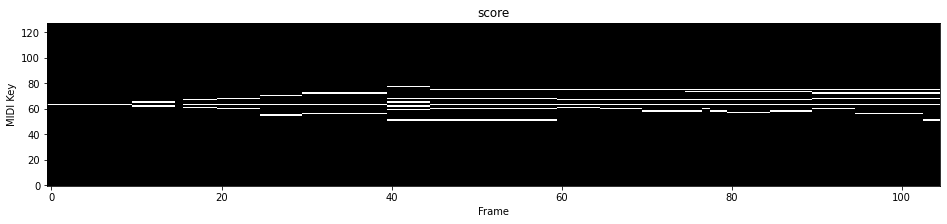

<Figure size 432x288 with 0 Axes>

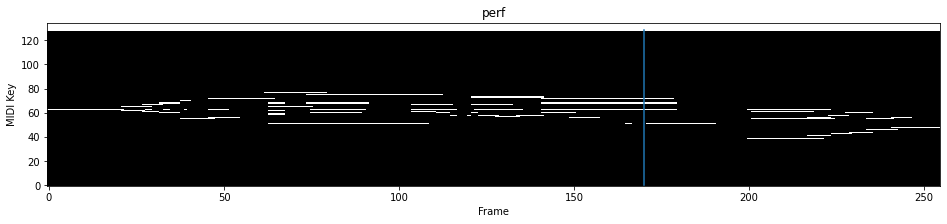

<Figure size 432x288 with 0 Axes>

In [7]:
plot_midi_matrix(score, "score")
plot_midi_matrix(perf, "perf", original_head, original_tail)

In [8]:
processed_score = process_midi_matrix(score, SETTLING_FRAME).T
processed_perf = process_midi_matrix(perf, SETTLING_FRAME).T

In [9]:
score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score,SETTLING_FRAME)
perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, SETTLING_FRAME)
score_sequence = score_unit_seq_list.to_representative_unit_sequence()
perf_sequence = perf_unit_seq_list.to_representative_unit_sequence()

In [10]:
cost, (predicted_head, predicted_tail), (warping_path, accumulated_cost_matrix, delta_functions) = similarity.algorithm.subsequence_matching(
    score_sequence, perf_sequence
)

In [11]:
original_subsequence_len = original_tail - original_head
predicted_subsequence_len = predicted_tail - predicted_head

length_accuracy = predicted_subsequence_len / original_subsequence_len
print(f"Length accuracy: {length_accuracy: .2f}")

Length accuracy:  0.98


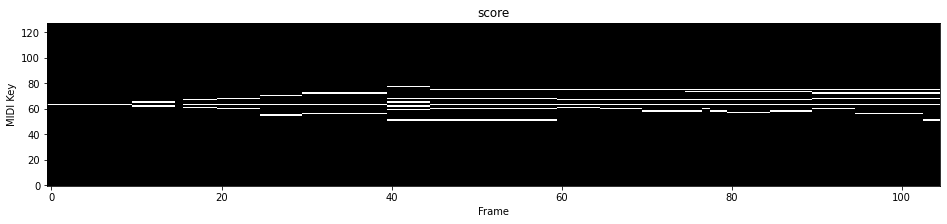

<Figure size 432x288 with 0 Axes>

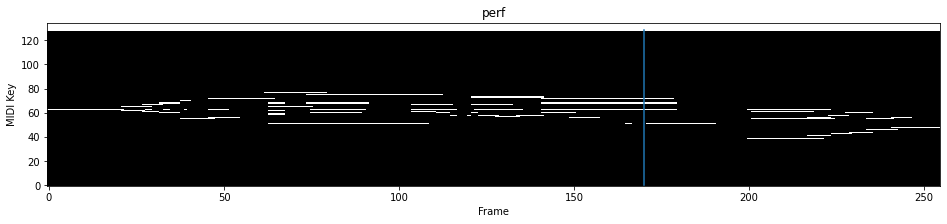

<Figure size 432x288 with 0 Axes>

In [12]:
plot_midi_matrix(score, "score")
plot_midi_matrix(perf, "perf", original_head, original_tail)

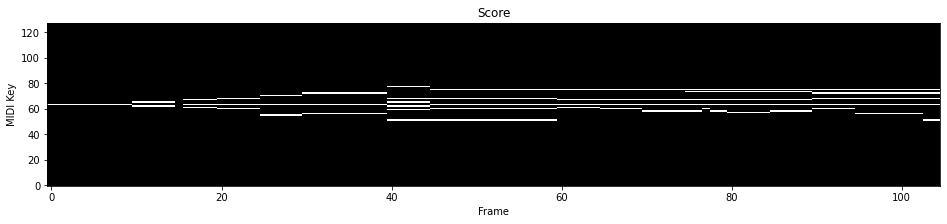

<Figure size 432x288 with 0 Axes>

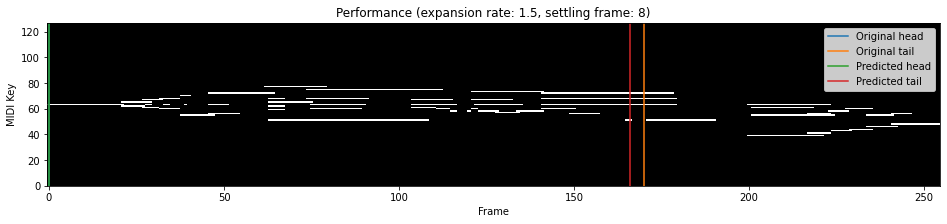

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(16, 3))
plt.title("Score")
plt.imshow(score, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.ylabel("MIDI Key")
plt.xlabel("Frame")
plt.show()
plt.clf()

plt.figure(figsize=(16, 3))
plt.title(f"Performance (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.imshow(perf, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.ylim(midi.MIN_MIDI_KEY, midi.MAX_MIDI_KEY)
plt.ylabel("MIDI Key")
plt.xlabel("Frame")
plt.plot([original_head, original_head], [0, 128], label="Original head")
plt.plot([original_tail, original_tail], [0, 128], label="Original tail")
plt.plot([predicted_head, predicted_head], [0, 128], label="Predicted head")
plt.plot([predicted_tail, predicted_tail], [0, 128], label="Predicted tail")
plt.legend()
plt.show()
plt.clf()

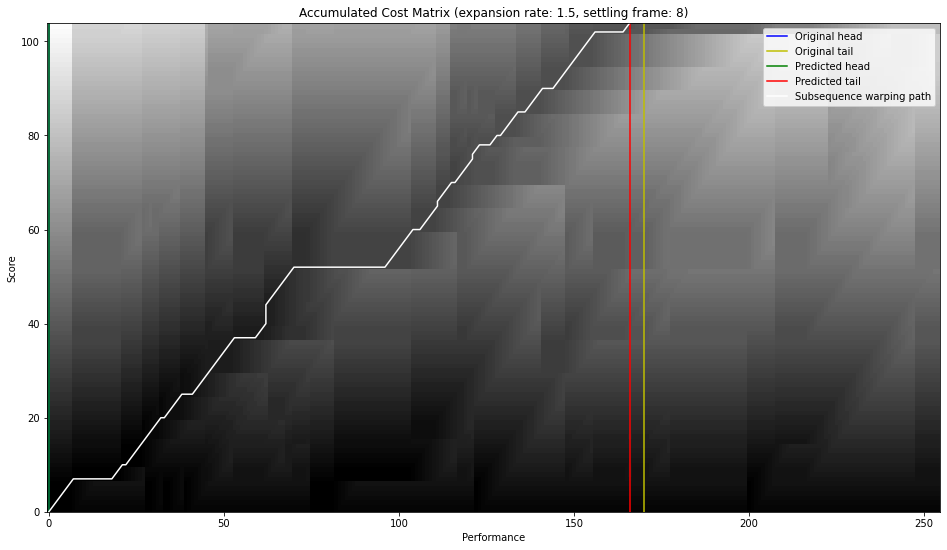

<Figure size 432x288 with 0 Axes>

In [14]:
ylim = [0, score.shape[-1] -1]
warping_path_ = np.array([(i, j) for (i, j) in warping_path])

plt.figure(figsize=(16, 9))
plt.title(f"Accumulated Cost Matrix (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.imshow(accumulated_cost_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.plot([original_head, original_head], ylim, "b", label="Original head")
plt.plot([original_tail, original_tail], ylim, "y", label="Original tail")
plt.plot([predicted_head, predicted_head], ylim, "g", label="Predicted head")
plt.plot([predicted_tail, predicted_tail], ylim, "r", label="Predicted tail")
plt.plot(warping_path_[:, 1], warping_path_[:, 0], 'w', label="Subsequence warping path")
plt.ylabel("Score")
plt.xlabel("Performance")
plt.ylim(ylim)
plt.legend()
plt.show()
plt.clf()

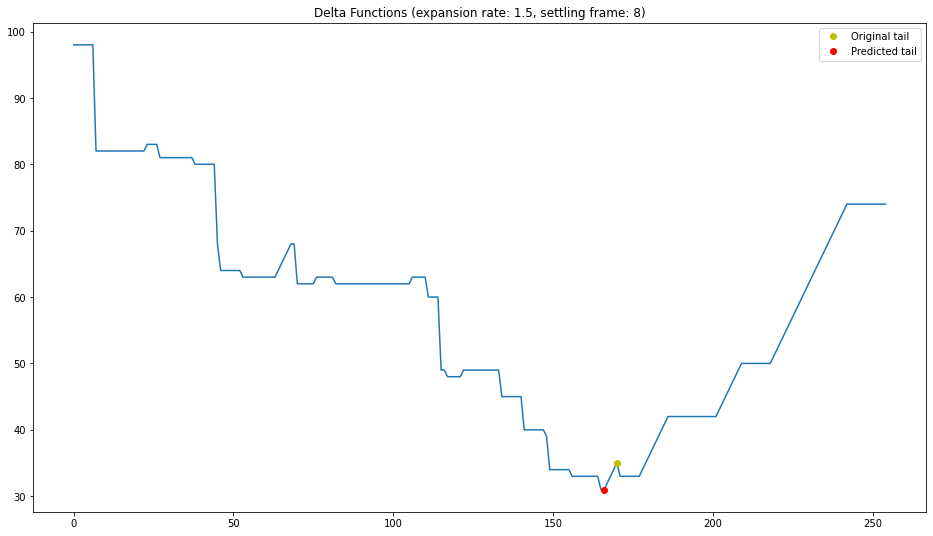

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(16, 9))
plt.title(f"Delta Functions (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.plot(np.arange(len(delta_functions)),delta_functions)
plt.plot(original_tail, delta_functions[original_tail], 'yo', label="Original tail")
plt.plot(predicted_tail, delta_functions[predicted_tail], 'ro', label="Predicted tail")
plt.legend()
plt.show()
plt.clf()

In [19]:
decayed_pitch_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=True)
print(decayed_pitch_histogram)

[0.19036697 0.08600917 0.05733945 0.17545871 0.         0.08600917
 0.         0.08600917 0.1571101  0.02866972 0.1043578  0.02866972]


In [18]:
not_decayed_pitch_histogram = score_unit_seq_list.to_pitch_histogram(with_decay=False)
print(not_decayed_pitch_histogram)

[0.13759214 0.05896806 0.02457002 0.43243244 0.         0.03685504
 0.         0.09582309 0.14250614 0.01228501 0.04668305 0.01228501]
